## ECE 285 - MLIP - Assignment 4
## Image Denosing with Deep CNNs

### 1. Getting started

In [1]:
%matplotlib notebook

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import math

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### 2. Creating noisy images of BSDS dataset with DataSet

#### 1. Create a variable dataset root dir and make it point to the BSDS dataset directory.

In [3]:
dataset_root_dir = '/datasets/ee285f-public/bsds/'

#### 2. As we built a dataset class in Assignment 3, we will do that here again to create our NoisyBSDSDataset. Interpret and complete the following piece of code:

In [4]:
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        # COMPLETE
        clean = clean.crop((i,j,i+self.image_size[0], j+self.image_size[1]))
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
            ])
        clean = transform(clean)
        
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

Interpretation:
> In the init method, we define self.mode, self.image_size, self.sigma, self.images_directory, self.files
> In the len method, we take the file length
> In the repr method, we get the format of representation
> In the getitem method, we convert the image to RGB format, then generate two random integer i and j, crop the size of the clean image, and resize it into shape (3, image_size, image_size), convert into two torch tensors, then normalize them to the range [-1, 1], and return the clean and noisy tensors.

#### 3. Create train_set qnd test_set as instances of NoisyImageDataset

In [5]:
train_set = NoisyBSDSDataset(dataset_root_dir, mode = "train")
test_set = NoisyBSDSDataset(dataset_root_dir, mode = "test", image_size = (320, 320))

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').detach().numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    plt.show()
    return h

clean & noisy plot

<IPython.core.display.Javascript object>


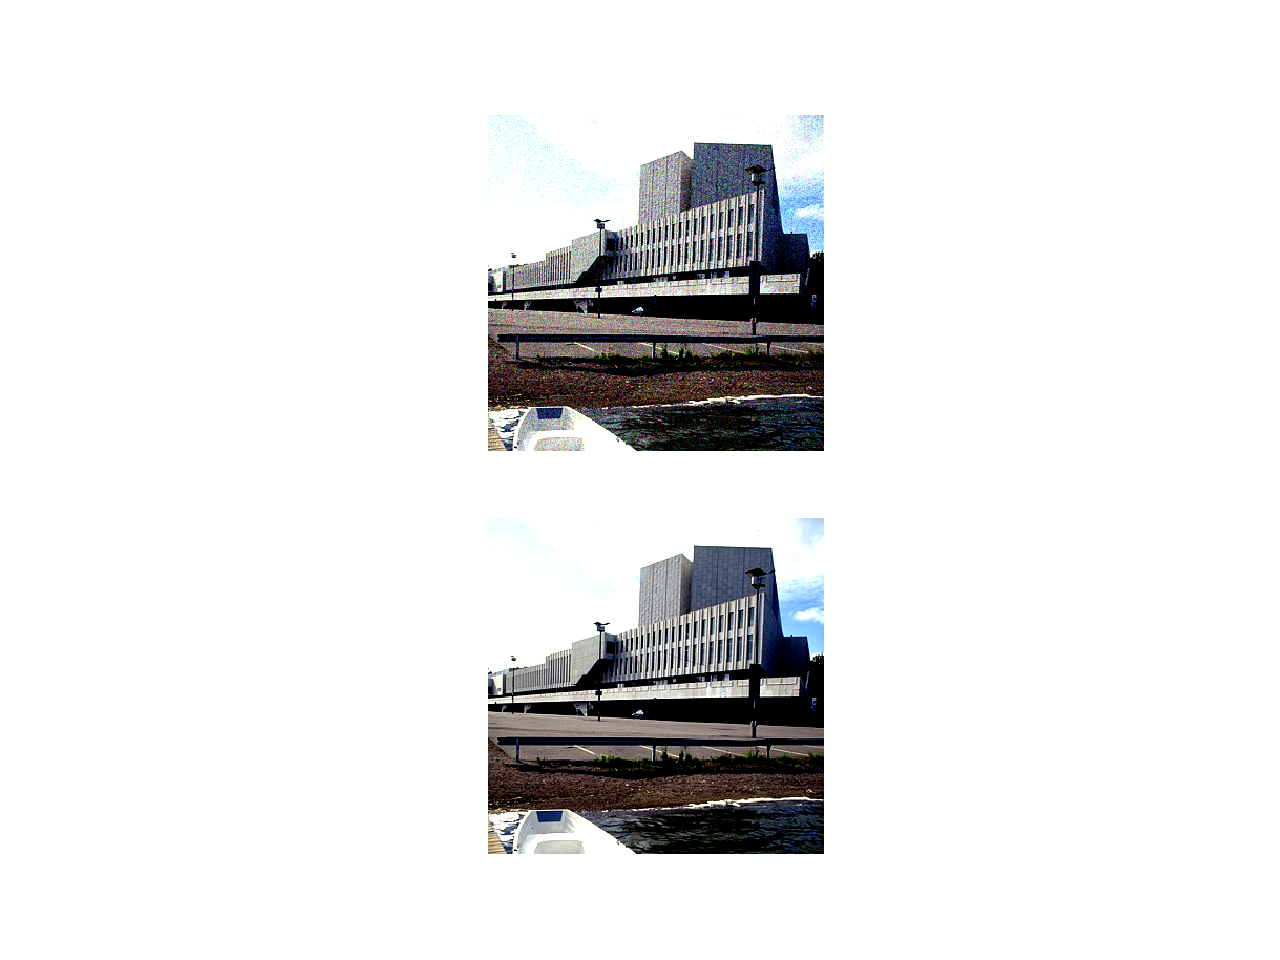

In [7]:
x = test_set.__getitem__(12)
myimshow(x[0], plt.subplot(2,1,1))
myimshow(x[1], plt.subplot(2,1,2))

### 3. DnCNN

#### 4. Similar to NNClassifier from Assignment 3, create a subclass NNRegressor that inherits from NeuralNetwork and implements the method criterion as being the MSE loss.

In [8]:
class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

#### 5. Copy, interpret and complete the following code implementing DnCNN:

In [9]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding = 1))
        # COMPLETE
        for i in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding = 1))
        self.conv.append(nn.Conv2d(C, 3, 3, padding = 1))
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
        # TO BE COMPLETED LATER IN QUESTION 7

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        # COMPLETE
        for k in range(D):
            h = F.relu(self.bn[k](self.conv[k+1](h)))
        y = self.conv[D+1](h) + x
        return y

Interpretation:
> In the init method, self.D (the layers of conv+BN+ReLU), the first layer of convolution is defined. And then append D layers convolutions into ModuleList, append D layers batch norm into Modulelist. 
> In the forward method, apply relu for the first convolution, then combine convolution, batch norm and ReLu into a block for the following D layers. Return the final result.

#### 6. Sample the last image of the training dataset, and store its noisy version in a variable x of shape (1, 3, 180, 180).

In [10]:
x_last, d_last = train_set.__getitem__(-1)

In [11]:
x = x_last.reshape(1,3,180,180)
print(x.size())

torch.Size([1, 3, 180, 180])


Create instances of DnCNN for D = 0, 1, 2, 4 and 8. For each of them feed-forward x, store the result in y, and display next to each other x[0], y[0] and x[0]-y[0].

<IPython.core.display.Javascript object>


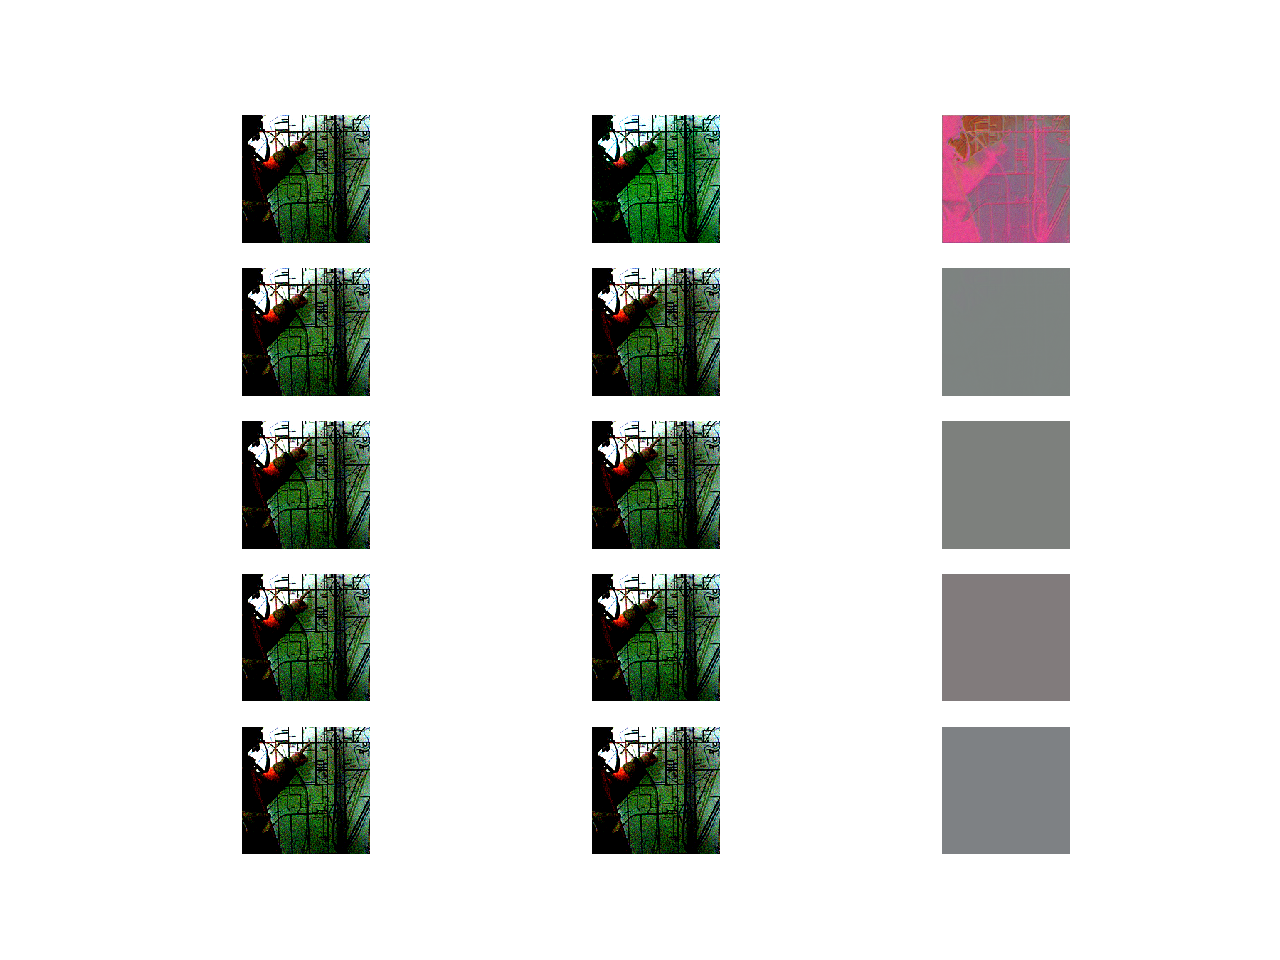

In [12]:
#DcCNN_0
DnCNN_0 = DnCNN(0)
y0 = DnCNN_0.forward(x)
myimshow(x[0], plt.subplot(5, 3, 1))
myimshow(y0[0], plt.subplot(5, 3, 2))
myimshow(x[0]-y0[0], plt.subplot(5, 3, 3))

#DnCNN_1
DnCNN_1 = DnCNN(1)
y1 = DnCNN_1.forward(x)
myimshow(x[0], plt.subplot(5, 3, 4))
myimshow(y1[0], plt.subplot(5, 3, 5))
myimshow(x[0]-y1[0], plt.subplot(5, 3, 6))

#DnCNN_2
DnCNN_2 = DnCNN(2)
y2 = DnCNN_2.forward(x)
myimshow(x[0], plt.subplot(5, 3, 7))
myimshow(y2[0], plt.subplot(5, 3, 8))
myimshow(x[0]-y2[0], plt.subplot(5, 3, 9))

#DnCNN_4
DnCNN_4 = DnCNN(4)
y3 = DnCNN_4.forward(x)
myimshow(x[0], plt.subplot(5, 3, 10))
myimshow(y3[0], plt.subplot(5, 3, 11))
myimshow(x[0]-y3[0], plt.subplot(5, 3, 12))

#DnCNN_8
DnCNN_8 = DnCNN(8)
y4 = DnCNN_8.forward(x)
myimshow(x[0], plt.subplot(5, 3, 13))
myimshow(y2[0], plt.subplot(5, 3, 14))
myimshow(x[0]-y4[0], plt.subplot(5, 3, 15))

What do you observe? What will be the implication on back-propagation?
> For all d > 0, clean and denoised images are exactly same. <br>
> It's hard to learn this function by back-propagation since the difference between clean and denoised images has already been zero.

#### 7. Modify DnCNN constructor (the init method)

In [13]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding = 1))
        # COMPLETE
        for i in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding = 1))
        self.conv.append(nn.Conv2d(C, 3, 3, padding = 1))
        for i in range(len(self.conv) - 1):
            nn.init.kaiming_normal_(self.conv[i].weight.data)
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
            nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        # COMPLETE
        for k in range(D):
            h = F.relu(self.bn[k](self.conv[k+1](h)))
        y = self.conv[D+1](h) + x
        return y

#### 8. Rerun the experiment from question 6. What do you observe? Why? What will be the implication on back-propagation?

<IPython.core.display.Javascript object>


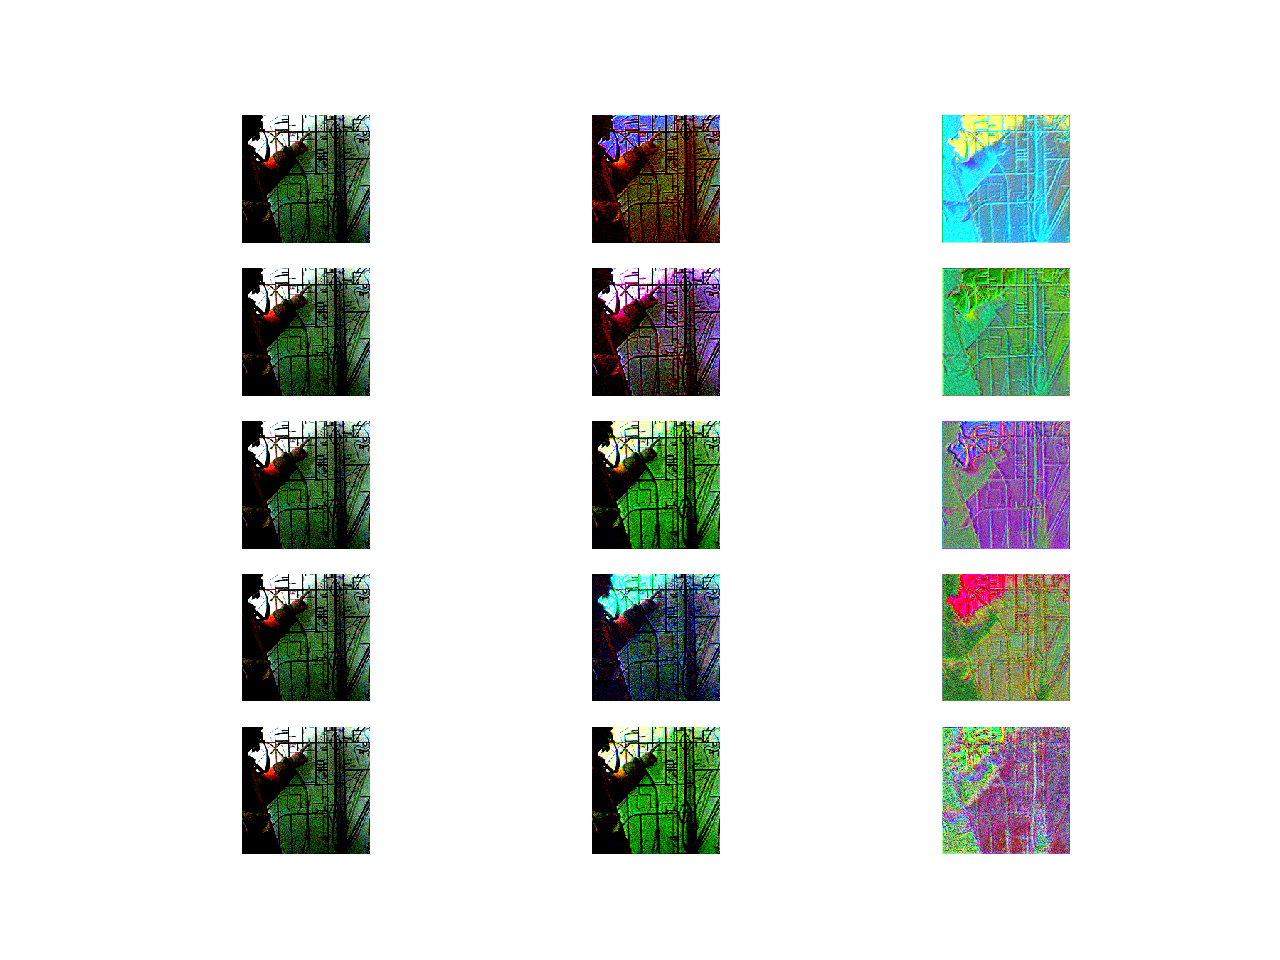

In [14]:
#DcCNN_0
DnCNN_0 = DnCNN(0)
y0 = DnCNN_0.forward(x)
myimshow(x[0], plt.subplot(5, 3, 1))
myimshow(y0[0], plt.subplot(5, 3, 2))
myimshow(x[0]-y0[0], plt.subplot(5, 3, 3))

#DnCNN_1
DnCNN_1 = DnCNN(1)
y1 = DnCNN_1.forward(x)
myimshow(x[0], plt.subplot(5, 3, 4))
myimshow(y1[0], plt.subplot(5, 3, 5))
myimshow(x[0]-y1[0], plt.subplot(5, 3, 6))

#DnCNN_2
DnCNN_2 = DnCNN(2)
y2 = DnCNN_2.forward(x)
myimshow(x[0], plt.subplot(5, 3, 7))
myimshow(y2[0], plt.subplot(5, 3, 8))
myimshow(x[0]-y2[0], plt.subplot(5, 3, 9))

#DnCNN_4
DnCNN_4 = DnCNN(4)
y3 = DnCNN_4.forward(x)
myimshow(x[0], plt.subplot(5, 3, 10))
myimshow(y3[0], plt.subplot(5, 3, 11))
myimshow(x[0]-y3[0], plt.subplot(5, 3, 12))

#DnCNN_8
DnCNN_8 = DnCNN(8)
y4 = DnCNN_8.forward(x)
myimshow(x[0], plt.subplot(5, 3, 13))
myimshow(y2[0], plt.subplot(5, 3, 14))
myimshow(x[0]-y4[0], plt.subplot(5, 3, 15))

What do you observe? Why? What will be the implication on back-propagation?
> (1) The clean and denoised images are different for either d = 0 or d > 0. <br>
> (2) In Q6 we apply zero initialization for weights, graident vanishing will happen thus making backprop hard, but if we apply He's initialization here, it's random, so gradient vanishing problem can be resolved. <br>
> (3) The implication on back-propagation will be much easier. <br>

#### 9. Use PSNR (Peak Signal-to-Noise-Ratio).

In [19]:
class DenoisingStatsManager(nt.StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_accuracy = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = 10 * math.log10(4/abs(loss))
        return {'loss': loss, 'psnr': psnr}

#### 10. Create a DnCNN network with D = 6 and transfer your network to GPU. Create an experiment exp1 for DnCNN based on Adam optimizer with learning rate 1e-3, using DenoisingStatsManager, mini batches of size 4, and storing the checkpoints in denoising1.

In [20]:
lr = 1e-3
net = DnCNN(6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, output_dir="denoising1", batch_size = 4, perform_validation_during_training=True)


#### 11. Run the experiment for 200 epochs after completing the following

In [21]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="training loss")
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)],
                 label="training psnr")
    
    plt.tight_layout()
    fig.canvas.draw()


<IPython.core.display.Javascript object>


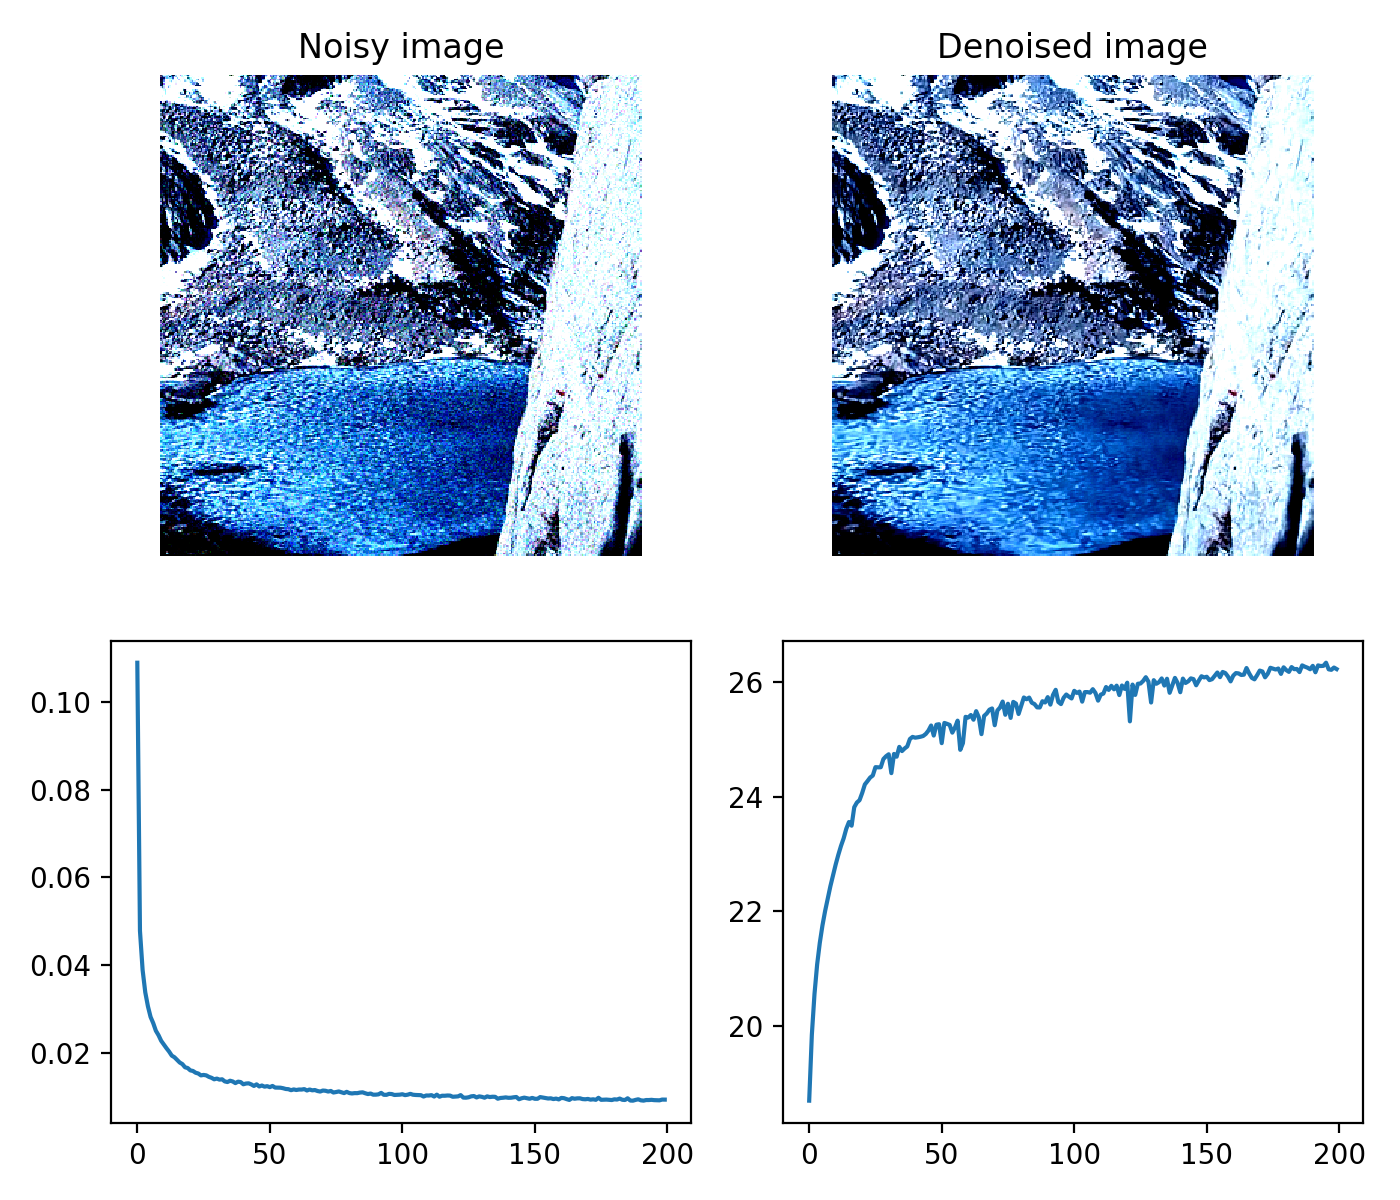

Start/Continue training from epoch 200
Finish training for 200 epochs


In [23]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

#### 12. Once you have trained your network for 200 epochs (about 17 minutes), compare the noisy, clean and denoised results on a few images of the testing set. Evaluate the visual quality of your result.

<IPython.core.display.Javascript object>


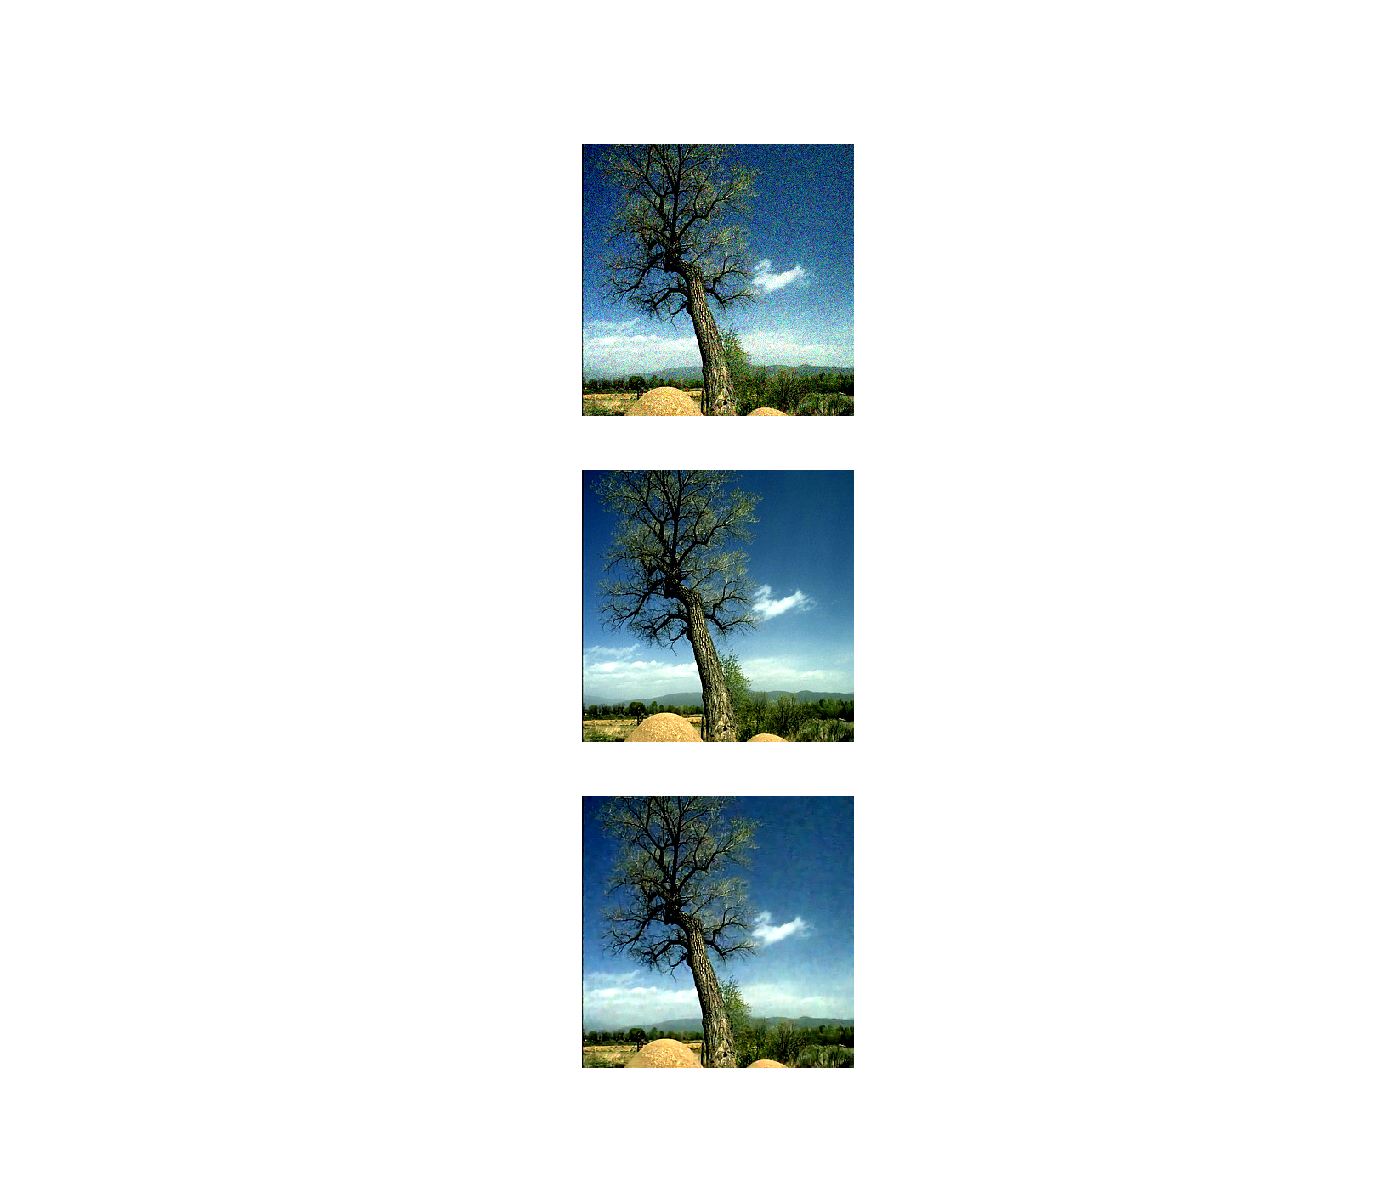

In [24]:
axes[0][0].clear()
axes[0][1].clear()
axes[0][2].clear()

x = test_set.__getitem__(26)
noisy = x[0]
clean = x[1]
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(7,6), sharex='all',sharey='all')
myimshow(noisy, plt.subplot(1,3,1))
axes[0][0].set_title('Noisy image')
myimshow(clean, plt.subplot(1,3,2))
axes[0][1].set_title('Clean image')
denoised = exp1.net(x[0][None].to(net.device))[0]
myimshow(denoised, plt.subplot(1,3,3))
axes[0][2].set_title('Denoised image')

Do you see any artifacts or loss of information?
> No.

#### 13. What is the number of parameters of DnCNN(D)? What is the receptive ﬁeld of DnCNN(D), i.e, how many input pixels do inﬂuence an output pixel?

number of parameters: 3523 + 37056D <br>
receptive field: (2(D+2)+1)^2<br>

#### 14. Denoising literature claims that for reducing Gaussian noise of standard deviation σ = 30 eﬃciently, a pixel should be inﬂuenced by at least 33 × 33 pixels. How large D (how deep) should DnCNN be to satisfy this constraint? What would be the implication on the number of parameters and the computation time?

2(D+2) + 1 = 33 --> D = 14 <br>
number of parameters will increase, computation time will decrease.

### 4 U-net like CNNs

#### 15. Copy paste the class DnCNN into a new class UDnCNN. Modify it to implement the U-shaped DnCNN.

In [79]:
class UDnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding = 1))
        # COMPLETE
        for i in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding = 1))
        self.conv.append(nn.Conv2d(C, 3, 3, padding = 1))
        for i in range(1,len(self.conv) - 1):
            nn.init.kaiming_normal_(self.conv[i].weight.data, a=0, mode='fan_in', nonlinearity='relu')
            
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
            nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))
            
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        first_h = h
        
        pooling_output = list()
        pooling_indices = list()
        
        for i in range(D//2 - 1):
            h = self.conv[i+1](h)
            h = self.bn[i](h)
            h = F.relu(h)
            h, indices = F.max_pool2d(input = h, kernel_size = 2, return_indices = True)
            pooling_output.append(h)
            pooling_indices.append(indices)
            
        if D % 2 == 0:
            h = self.conv[D//2](h)
            h = self.bn[D//2](h)
            h = F.relu(h)
        
        for i in range(D//2):
            if i != 0:
                indices = pooling_indices[D//2-1-i]
                h = F.max_unpool2d(input = h, kernel_size = 2, indices = indices)
            k = D//2 + i
            h = self.conv[k+1](h)
            h = self.bn[k](h)
            h = F.relu(h)
            if i != D//2-1:
                h += pooling_output[D//2-2-i]
                h /= math.sqrt(2)
                
        h += first_h
        h /= math.sqrt(2)

        y = self.conv[D+1](h) + x
        return y
                

#### 16. Create a new experiment exp2 for UDnCNN based on Adam optimizer with learning rate 1e-3, using DenoisingStatsManager, mini batches of size 4, and storing the checkpoints in denoising2.

In [80]:
lr = 1e-3
net = UDnCNN(6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp2 = nt.Experiment(net, train_set, test_set, adam, stats_manager, output_dir="denoising2", batch_size = 4, perform_validation_during_training=True)


<IPython.core.display.Javascript object>


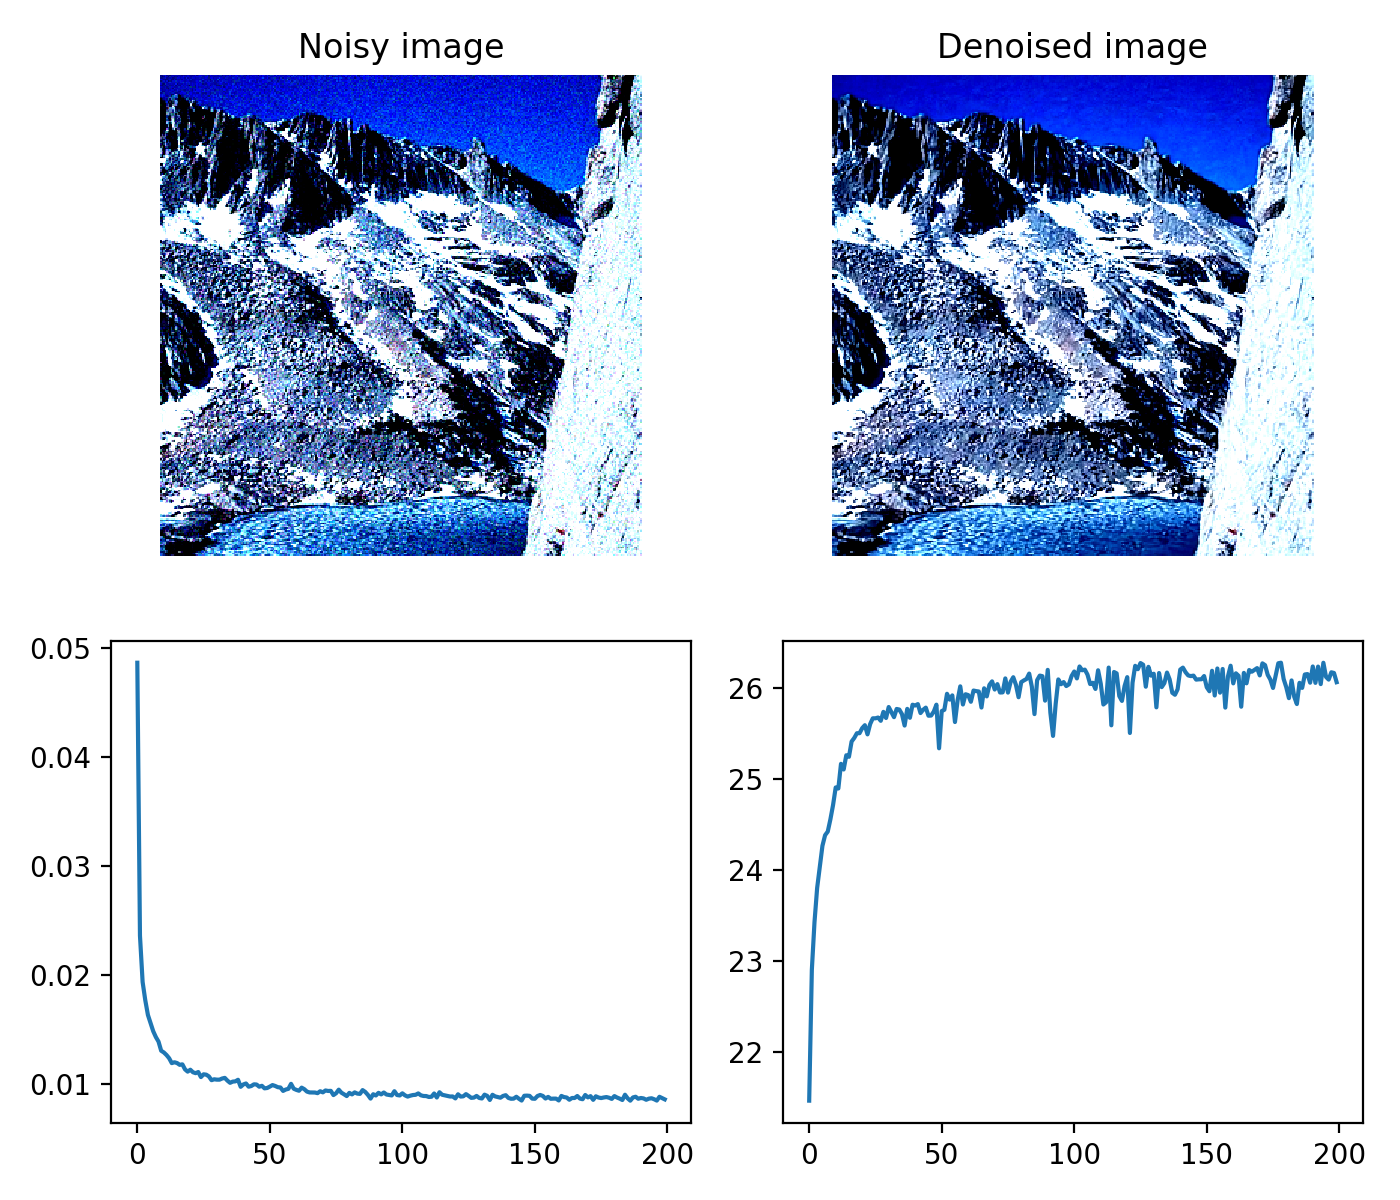

Start/Continue training from epoch 200
Finish training for 200 epochs


In [28]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp2.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

#### 17. <br>
>What is the number of parameters of UDnCNN(D)?    <br>
>   3523 + 37056D <br> 
>What is the receptive ﬁeld of UDnCNN(D)? <br>
> D = 6: 33 <br>
>Do you expect UDnCNN(D) to beat DnCNN(D)? <br>
>Yes  <br>

#### 18. Using the method evaluate of Experiement, compare the validation performance of DnCNN and UDnCNN. Interpret the results.

In [44]:
exp1.evaluate()

{'loss': 0.009609497133642435, 'psnr': 26.193593297570622}

In [29]:
exp2.evaluate()

{'loss': 0.010042137037962674, 'psnr': 26.002338477386566}

Interpret the result:
> DnCNN perform better than UDnCNN. Even though we introduce max/un-pooling to largen the receptive field, the exact locations of features are lost and this introduces artifacts in the results (hence lower PSNR).

#### 19. Copy paste the class DnCNN into a new class DUDnCNN and modify it to implement the Dilated U-shaped DnCNN. Each convolution placed after k pooling and l unpooling in the network, should be replaced by a dilated ﬁlter with 2 k−l − 1 holes. This can be achieved with the dilation optional argument of nn.Conv2d. Make sure you set up the argument padding accordingly in order to maintain tensors with the same spatial dimension during the forward propagation.

In [32]:
class DUDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding = 1))
        
        k, l = 0, 0
        
        for i in range(D):
            if i % 1 == 0:
                if i < D //2 - 1:
                    self.conv.append(nn.Conv2d(C, C, 3, padding = 1, 
                                              dilation = 2**(k-l)))
                    k += 1
                elif D //2 - 1 <= i < D // 2 + 1:
                    self.conv.append(nn.Conv2d(C, C, 3, padding = 1,
                                              dilation = 2**(k-l)))
                else:
                    l += 1
                    self.conv.append(nn.Conv2d(C, C, 3, padding = 1,
                                              dilation = 2**(k-l)))
            else:
                if i < D // 2:
                    self.conv.append(nn.Conv2d(C, C, 3, padding = 1,
                                              dilation = 2**(k-l)))
                    k += 1
                elif D //2 <= i < D //2 + 1:
                    self.conv.append(nn.Conv2d(C, C, 3, padding = 1,
                                              dilation = 2**(k-l)))
                else:
                    l += 1
                    self.conv.append(nn.Conv2d(C, C, 3, padding = 1,
                                              dilation = 2**(k-l)))
        self.conv.append(nn.Conv2d(C, 3, 3, padding = 1, dilation = 1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
            
        for i in range(len(self.conv) - 1):
            nn.init.kaiming_normal_(self.conv[i].weight.data)
            
        for k in range(len(self.bn)):
            nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))
            
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        first_h = h
        
        pooling_output = list()
        pooling_indices = list()
        
        indices = 0
        
        for i in range(D//2 - 1):
            h = self.conv[i+1](h)
            h = self.bn[i](h)
            h = F.relu(h)
            
            pooling_output.append(h)
            pooling_indices.append(indices)
            indices += 1
            
        if D % 2 == 0:
            h = self.conv[D//2](h)
            h = self.bn[D//2](h)
            h = F.relu(h)
        
        for i in range(D//2):
            
            k = D//2 + i
            h = self.conv[k+1](h)
            h = self.bn[k](h)
            h = F.relu(h)
            if i != D//2-1:
                h += pooling_output[D//2-2-i]
                h /= math.sqrt(2)
                
        h += first_h
        h /= math.sqrt(2)

        y = self.conv[D+1](h) + x
        return y
                     

#### 20. add the two instructions

In [73]:
class DUDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding = 1, dilation = 1))
        
        pooling_cnt= 0
        unpooling_cnt = 0
        
        for k in range(D):
            if k > D / 2:
                unpooling_cnt += 1
            dilation = 2 ** (pooling_cnt - unpooling_cnt)
            self.conv.append(nn.Conv2d(C, C, 3, padding = ((3+2*(dilation - 1)-1)//2), dilation = dilation))
            if k < D / 2 - 1:
                pooling_cnt += 1
            
        self.conv.append(nn.Conv2d(C, 3, 3, padding = 1, dilation = 1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
            
        for i in range(len(self.conv) - 1):
            nn.init.kaiming_normal_(self.conv[i].weight.data)
            
        for k in range(len(self.bn)):
            nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))
            
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        first_h = h
        
        pooling_output = list()
        pooling_indices = list()
        
        indices = 0
        
        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark - False
            h = self.bn[i](h)
            h = F.relu(h)
            
            pooling_output.append(h)
            pooling_indices.append(indices)
            indices += 1
            
        if D % 2 == 0:
            torch.backends.cudnn.benchmark = True
            h = self.conv[D//2](h)
            torch.backends.cudnn.benchmark = False
            h = self.bn[D//2](h)
            h = F.relu(h)
        
        for i in range(D//2):
            k = D//2 + i
            torch.backends.cudnn.benchmark = True
            h = self.conv[k+1](h)
            torch.backends.cudnn.benchmark = False
            h = self.bn[k](h)
            h = F.relu(h)
            if i != D//2-1:
                h += pooling_output[D//2-2-i]
                h /= math.sqrt(2)
                
        h += first_h
        h /= math.sqrt(2)

        y = self.conv[D+1](h) + x
        return y
                     

#### 21. Create a new experiment for DUDnCNN based on Adam optimizer with learning rate 1e-3, using DenoisingStatsManager, mini batches of size 4, and storing the checkpoints in denoising3. Run your experiment for 200 epochs (about 20 minutes) using the same function plot as before.

In [74]:
lr = 1e-3
net = DUDnCNN(6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3 = nt.Experiment(net, train_set, test_set, adam, stats_manager, output_dir="denoising3", batch_size = 4, perform_validation_during_training=True)


<IPython.core.display.Javascript object>


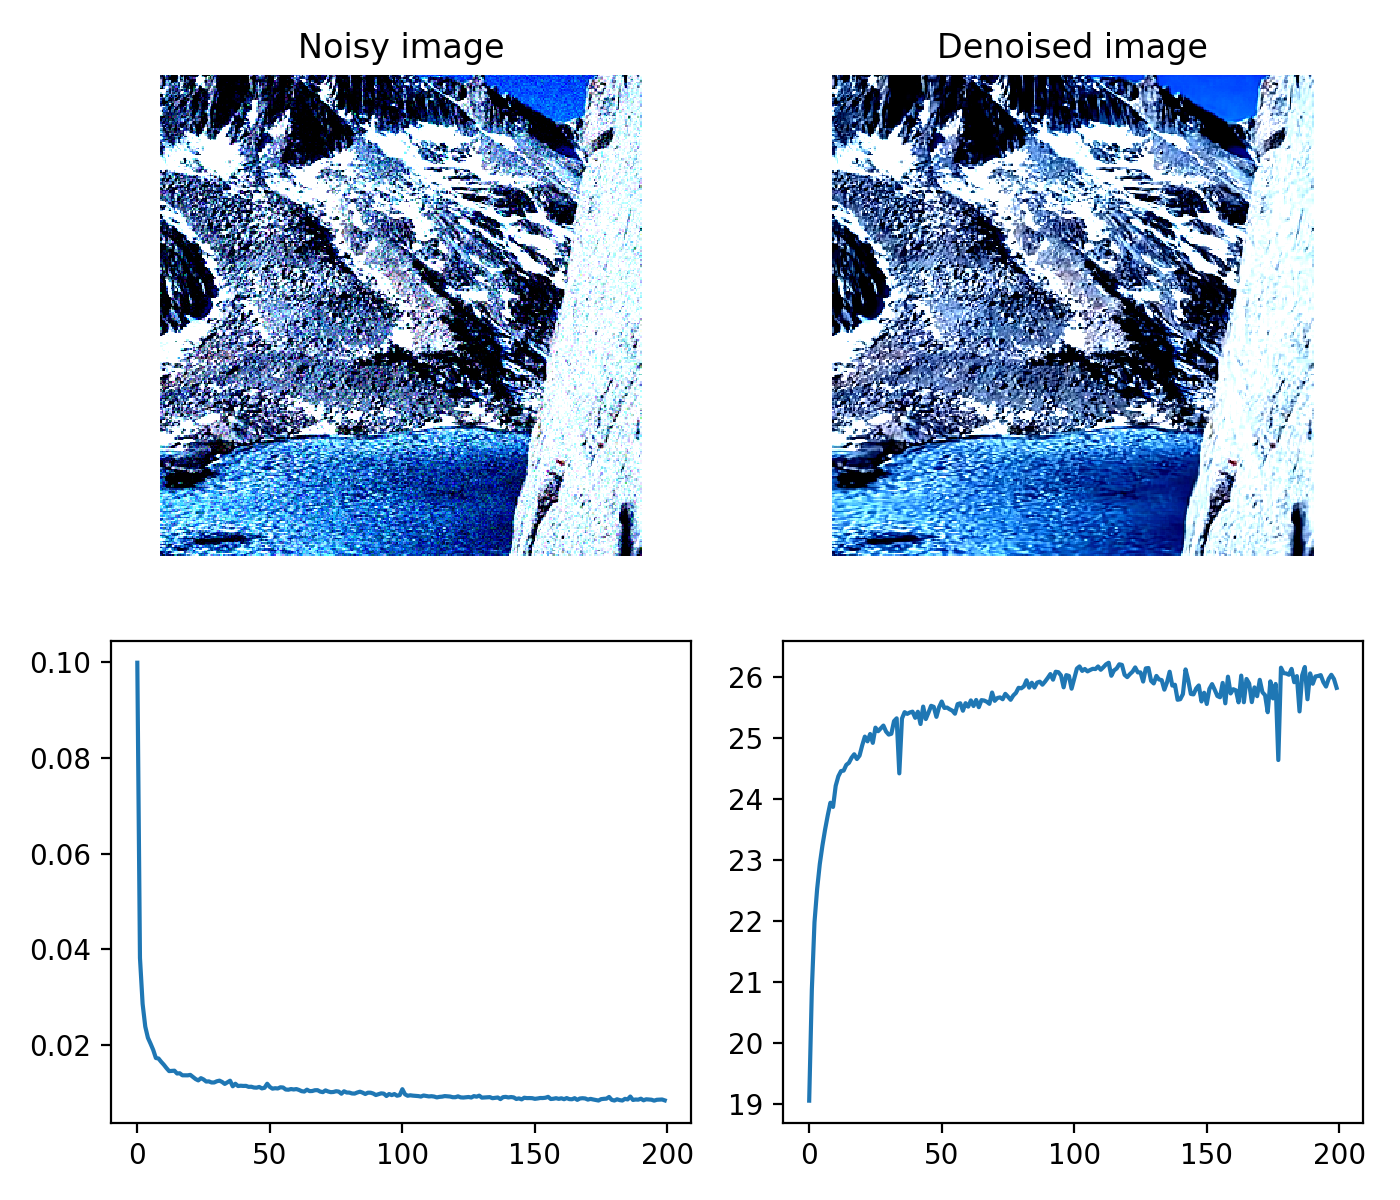

Start/Continue training from epoch 200
Finish training for 200 epochs


In [77]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp3.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

#### 22. Compare the validation performance of DnCNN, UDnCNN and DUDnCNN. Display results from a few samples of the testing set. Make sure your results are similar to the ones shown on Figure 1.

<IPython.core.display.Javascript object>


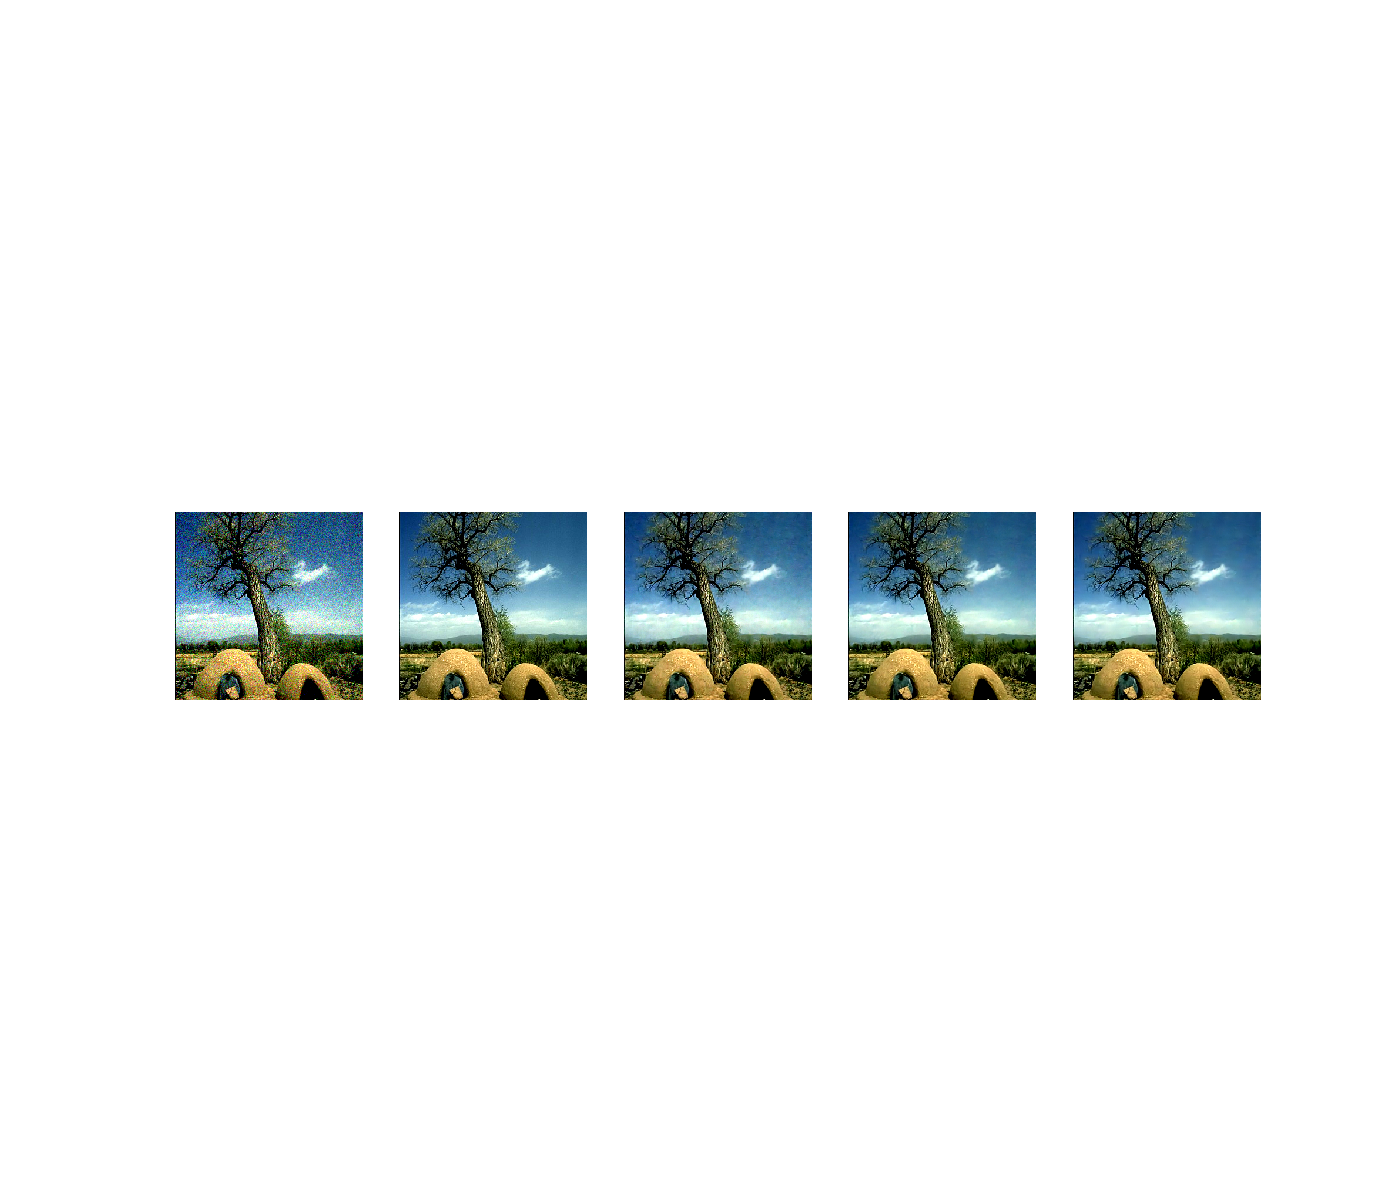

In [81]:
x = test_set.__getitem__(26)
noisy = x[0]
clean = x[1]
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(7,6), sharex='all',sharey='all')
myimshow(noisy, plt.subplot(1,5,1))
myimshow(clean, plt.subplot(1,5,2))
# DnCNN
denoised = exp1.net(x[0][None].to(net.device))[0]
myimshow(denoised, plt.subplot(1,5,3))
# UDnCNN
denoised = exp2.net(x[0][None].to(net.device))[0]
myimshow(denoised, plt.subplot(1,5,4))
# DUDnCNN
denoised = exp3.net(x[0][None].to(net.device))[0]
myimshow(denoised, plt.subplot(1,5,5))


#### 23. What is the number of parameters of DUDnCNN(D)? What is the receptive ﬁeld of DUDnCNN(D)?

number of parameters: 3523 + 37056D <br>
receptive field: Same as UDnCNN <br>